# Predicting ASD diagnosis from Genetic Data

Author: Rachael Caelie "Rocky" Aikens

Created: Dec 7, 2017

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split

## Data preprocessing

We have genotype information for siblings from the Agre and Simons Simplex Collection, which has been featurized into a binary matrix (described below). In addition to that, we have imputed ASD/non-ASD labels and ADOS/ADI-R scores for a subset of those individuals.

### Feature Data (Genotype)

The input data is represented as a binary matrix.  There are a couple different representations we can use here, but to start I will use 1 = loss of function variant(compound het or homozygous alternate), 0 = no loss of function variant.

In [2]:
# load input feature dataset for Agre
Agre_asd = pd.read_csv("data/v34_lof_asd_af0.50.txt", index_col=0).transpose()
Agre_ctrl = pd.read_csv("data/v34_lof_typical_af0.50.txt", index_col=0).transpose()

print "Cases: ", Agre_asd.shape[0]
print "Controls: ", Agre_ctrl.shape[0]

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-2-e15b414308ed>, line 5)

In [9]:
# load input feature dataset for SSC
SSC_asd = pd.read_csv("data/SSC_lof_asd_af0.50.txt", index_col=0).transpose()
SSC_ctrl = pd.read_csv("data/SSC_lof_typical_af0.50.txt", index_col=0).transpose()

print "Cases: ", SSC_asd.shape[0]
print "Controls: ", SSC_ctrl.shape[0]

Cases:  517
Controls:  518


In [10]:
# merge SSC and Agre data
X_asd = pd.concat([SSC_asd, Agre_asd], axis = 0).fillna(0)
X_ctrl = pd.concat([SSC_ctrl, Agre_ctrl], axis = 0).fillna(0)
X = pd.concat([X_asd, X_ctrl], axis=0)
print "Total cases: ", X_asd.shape[0]
print "Total controls: ", X_ctrl.shape[0]
print "Features (ie. genes): ", X.shape[1]
print "Missing Values: ", int(X.isnull().values.any())

Total cases:  2133
Total controls:  867
Features (ie. genes):  1109
Missing Values:  0


### Target Data (ASD/non-ASD diagnosis)

We have a file that Kelley has made with inferred Autism/Control diagnosis for the individuals in the iHart study.  We will try and predict diagnosis 0 = Control, 1 = Austism.

In [11]:
y = pd.read_csv("data/all_samples_filtered_labels.csv", usecols = ['identifier','diagnosis'], index_col=0)

In [12]:
# shift y to a 0/1 representation for Control/ASD
y["diagnosis"] = np.where(y['diagnosis'] == 'Autism', 1, 0)

### Filtering for Overlap

Our phenotype labels y may not perfectly overlap with our genotype data, X.

In [13]:
# get lists of individuals in X and Y
m_x = X.index.values.tolist()
m_x_asd = X_asd.index.tolist()
m_x_ctrl = X_ctrl.index.tolist()
m_y = y.index.values.tolist()

# check subject overlap between X and Y
print "%d subjects in X are not in y.  Of these, %d are cases and %d are controls." % (len(set(m_x) - set(m_y)), len(set(m_x_asd) - set(m_y)), len(set(m_x_ctrl) - set(m_y)))

# make a list of Subject IDs with overlap
subjects = list(set(m_x) & set(m_y))
print "This leaves %d subjects: %d cases and %d controls." % (len(subjects), len(set(m_x_asd) & set(m_y)), len(set(m_x_ctrl)&set(m_y))) 

868 subjects in X are not in y.  Of these, 5 are cases and 863 are controls.
This leaves 2132 subjects: 2128 cases and 4 controls.


**Note:** The set of "cases" and "controls" appear to be differently defined between the iHart Phenotype labels (i.e. our `y` labels) and the CGT matrix labels (i.e. our `X` features). 

You can notice that the majority of controls don't appear in our phenotype information dataset. This is because ADOS\ADI-R was not administered to many controls from SSC and Agre. Since we're interested in classifying ASD/non-ASD, for our purposes it is not necessary to exclude these individuals because we do not necessarily need any phenotype information outside of diagnosis. Rather, we can infer that all individuals in a 'control' CGT matrix without ADOS/ADI-R information have a non-ASD diagnosis.

In [14]:
# add in controls without explicit diagnosis
to_add = list(set(m_x_ctrl) - set(m_y))
y_ctrl = pd.DataFrame(np.zeros(len(to_add),), columns = ['diagnosis'],index = to_add)
y = pd.concat([y, y_ctrl], axis = 0)
subjects = subjects + to_add

# redefine X and Y to contain only the subjects we want
X = X.ix[subjects]
y = y.ix[subjects]

# check we have the same subject IDs in the same order for X and Y
print y.index.values.tolist() == X.index.values.tolist()
y = y.ix[:,0]
print y.value_counts()

True
1.0    2088
0.0     907
Name: diagnosis, dtype: int64


One thing that's probably going to be an issue for this experiment is that there are very few controls for whom we have both genetic and ADOS/ADI-R information.  This is going to mean that a random classifier performs with fairly high accuracy, just because classifying most or all individuals as autistic is a effective strategy when we have so few negatives. 

## Data Splitting

Since we have ~1,600 examples, I'm going to hold out 20% of the data as a test set and then do 5 fold cross validation using built-in sklearn methods.

In [15]:
random.seed(143)
from class_SibKFold import SibKFold
skf = SibKFold(5, X)
train_ids, test_ids = skf.split(X)[0]
X_train = X.ix[train_ids]
X_test = X.ix[test_ids]
y_train = y.ix[train_ids]
y_test = y.ix[test_ids]

In [16]:
print len(train_ids)
print len(test_ids)

2397
598


# Gradient Boosted Classifier

In [17]:
# Import EvalLR
import class_EvalGBM
reload(class_EvalGBM)
from class_EvalGBM import EvalGBM


Running cross validation for fold 1:
Train Score: 0.848041 Test Score: 0.588207
AU-ROC 0.588207174627

Optimum threshold to maximize training accuracy: 0.656351065665
F1: 0.787072243346
Accuracy: 0.672514619883
Confusion Matrix:
[[ 23  76]
 [ 36 207]]


/scratch/PI/dpwall/computeEnvironments/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Optimum threshold to maximize f1: 0.629805153261
F1: 0.810313075506
Accuracy: 0.698830409357
Confusion Matrix:
[[ 19  80]
 [ 23 220]]
None


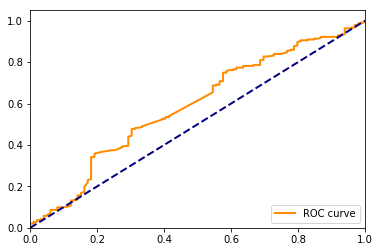


Running cross validation for fold 2:
Train Score: 0.842774 Test Score: 0.621455
AU-ROC 0.621454918033

Optimum threshold to maximize training accuracy: 0.641732289416
F1: 0.790786948177
Accuracy: 0.683139534884
Confusion Matrix:
[[ 29  71]
 [ 38 206]]

Optimum threshold to maximize f1: 0.629655992261
F1: 0.788571428571
Accuracy: 0.677325581395
Confusion Matrix:
[[ 26  74]
 [ 37 207]]
None


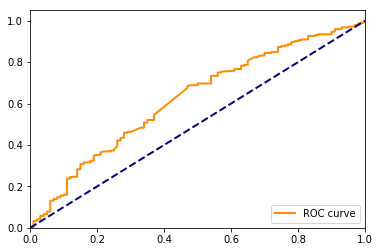


Running cross validation for fold 3:
Train Score: 0.855910 Test Score: 0.563840
AU-ROC 0.563839761347

Optimum threshold to maximize training accuracy: 0.657935286988
F1: 0.756435643564
Accuracy: 0.640350877193
Confusion Matrix:
[[ 28  67]
 [ 56 191]]

Optimum threshold to maximize f1: 0.617732096414
F1: 0.797752808989
Accuracy: 0.684210526316
Confusion Matrix:
[[ 21  74]
 [ 34 213]]
None


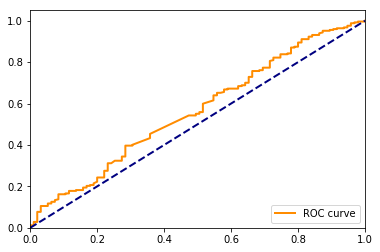


Running cross validation for fold 4:
Train Score: 0.855276 Test Score: 0.543775
AU-ROC 0.54377462569

Optimum threshold to maximize training accuracy: 0.662565714239
F1: 0.745562130178
Accuracy: 0.623906705539
Confusion Matrix:
[[ 25  83]
 [ 46 189]]

Optimum threshold to maximize f1: 0.642638067076
F1: 0.758220502901
Accuracy: 0.63556851312
Confusion Matrix:
[[ 22  86]
 [ 39 196]]
None


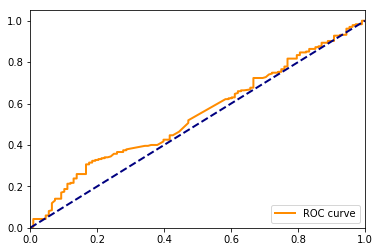


Running cross validation for fold 5:
Train Score: 0.866638 Test Score: 0.588027
AU-ROC 0.588027035726

Optimum threshold to maximize training accuracy: 0.636406300336
F1: 0.783938814532
Accuracy: 0.67055393586
Confusion Matrix:
[[ 25  79]
 [ 34 205]]

Optimum threshold to maximize f1: 0.636406300336
F1: 0.783938814532
Accuracy: 0.67055393586
Confusion Matrix:
[[ 25  79]
 [ 34 205]]
None


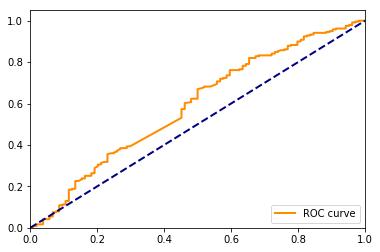


Running cross validation for fold 6:
Train Score: 0.853605 Test Score: 0.574014
AU-ROC 0.574013892838

Optimum threshold to maximize training accuracy: 0.653361845933
F1: 0.75390625
Accuracy: 0.631578947368
Confusion Matrix:
[[ 23  80]
 [ 46 193]]

Optimum threshold to maximize f1: 0.621619713147
F1: 0.775894538606
Accuracy: 0.652046783626
Confusion Matrix:
[[ 17  86]
 [ 33 206]]
None


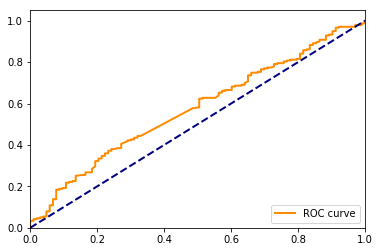


Running cross validation for fold 7:
Train Score: 0.871044 Test Score: 0.598649
AU-ROC 0.598648648649

Optimum threshold to maximize training accuracy: 0.66981954967
F1: 0.742857142857
Accuracy: 0.630498533724
Confusion Matrix:
[[ 33  78]
 [ 48 182]]

Optimum threshold to maximize f1: 0.658208973296
F1: 0.757936507937
Accuracy: 0.642228739003
Confusion Matrix:
[[ 28  83]
 [ 39 191]]
None


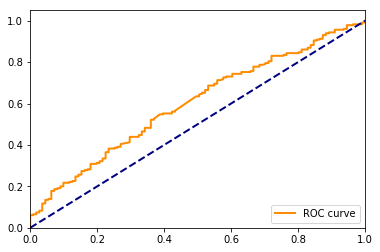

  Train_score Test_score
1    0.848041   0.588207
2    0.842774   0.621455
3     0.85591    0.56384
4    0.855276   0.543775
5    0.866638   0.588027
6    0.853605   0.574014
7    0.871044   0.598649


In [18]:
# base classifier without resampling
evalgbm = EvalGBM(X_train, y_train)
scores = evalgbm.kfold(7, True)
print scores

In [19]:
print np.mean(scores.Test_score)

0.582566579558


Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 1:
Train Score: 0.895357 Test Score: 0.578054
AU-ROC 0.578053605504

Optimum threshold to maximize training accuracy: 0.498077914177
F1: 0.552845528455
Accuracy: 0.539748953975
Confusion Matrix:
[[122 117]
 [103 136]]

Optimum threshold to maximize f1: 0.476992450606
F1: 0.631578947368
Accuracy: 0.546025104603
Confusion Matrix:
[[ 75 164]
 [ 53 186]]
None


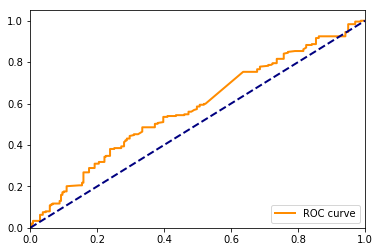

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 2:
Train Score: 0.876747 Test Score: 0.563068
AU-ROC 0.563067873462

Optimum threshold to maximize training accuracy: 0.503092227073
F1: 0.584392014519
Accuracy: 0.520920502092
Confusion Matrix:
[[ 88 151]
 [ 78 161]]

Optimum threshold to maximize f1: 0.480686705817
F1: 0.611295681063
Accuracy: 0.510460251046
Confusion Matrix:
[[ 60 179]
 [ 55 184]]
None


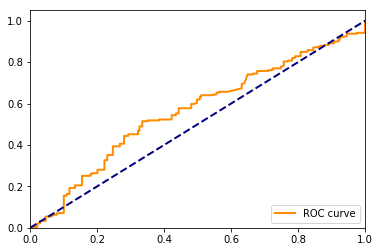

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 3:
Train Score: 0.896262 Test Score: 0.578725
AU-ROC 0.578725477022

Optimum threshold to maximize training accuracy: 0.484703965155
F1: 0.631578947368
Accuracy: 0.584016393443
Confusion Matrix:
[[111 133]
 [ 70 174]]

Optimum threshold to maximize f1: 0.484703965155
F1: 0.631578947368
Accuracy: 0.584016393443
Confusion Matrix:
[[111 133]
 [ 70 174]]
None


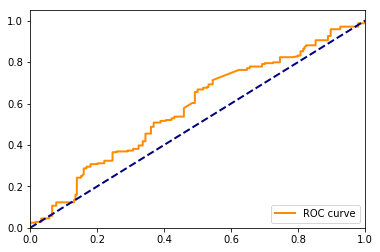

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 4:
Train Score: 0.894444 Test Score: 0.580662
AU-ROC 0.580662103254

Optimum threshold to maximize training accuracy: 0.497004128724
F1: 0.574898785425
Accuracy: 0.560669456067
Confusion Matrix:
[[126 113]
 [ 97 142]]

Optimum threshold to maximize f1: 0.482089815313
F1: 0.629173989455
Accuracy: 0.558577405858
Confusion Matrix:
[[ 88 151]
 [ 60 179]]
None


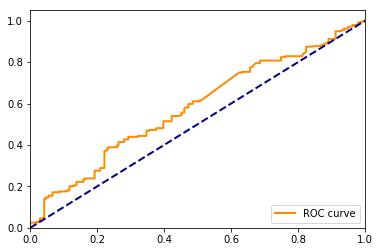

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 5:
Train Score: 0.894640 Test Score: 0.556895
AU-ROC 0.556895020832

Optimum threshold to maximize training accuracy: 0.50527886593
F1: 0.534113060429
Accuracy: 0.506198347107
Confusion Matrix:
[[108 134]
 [105 137]]

Optimum threshold to maximize f1: 0.482334146734
F1: 0.614864864865
Accuracy: 0.528925619835
Confusion Matrix:
[[ 74 168]
 [ 60 182]]
None


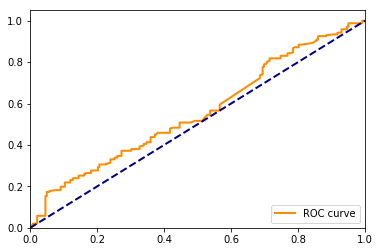

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 6:
Train Score: 0.886338 Test Score: 0.593955
AU-ROC 0.593954993888

Optimum threshold to maximize training accuracy: 0.50728915302
F1: 0.588235294118
Accuracy: 0.564315352697
Confusion Matrix:
[[122 119]
 [ 91 150]]

Optimum threshold to maximize f1: 0.482751400355
F1: 0.621035058431
Accuracy: 0.529045643154
Confusion Matrix:
[[ 69 172]
 [ 55 186]]
None


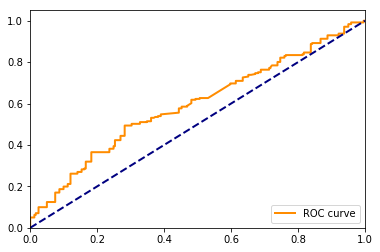

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 7:
Train Score: 0.904781 Test Score: 0.531848
AU-ROC 0.531848072354

Optimum threshold to maximize training accuracy: 0.490698012641
F1: 0.611599297012
Accuracy: 0.525751072961
Confusion Matrix:
[[ 71 162]
 [ 59 174]]

Optimum threshold to maximize f1: 0.479744107639
F1: 0.62925170068
Accuracy: 0.532188841202
Confusion Matrix:
[[ 63 170]
 [ 48 185]]
None


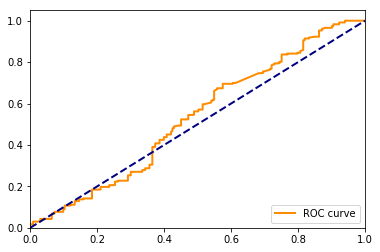

  Train_score Test_score
1    0.895357   0.578054
2    0.876747   0.563068
3    0.896262   0.578725
4    0.894444   0.580662
5     0.89464   0.556895
6    0.886338   0.593955
7    0.904781   0.531848


In [20]:
# classify again with resampling
scores = evalgbm.kfold(7, True, resample = True)
print scores

In [21]:
print np.mean(scores.Test_score)

0.569029592331


# Tuning parameters

One possible parameter we can tune is `n_trees`, which determines the number of estimators to build. The code below measures model performance for a variety of hyperparameter values.

In [22]:
# create a plot of preformance versus f1 score for different c values
def reg_plot(ntree_vals, X_train, y_train, resample = True):
    ntree_scores = []
    print "Running 7-fold cross validation for:"
    for i in range(len(ntree_vals)):
        print "C = %f" % ntree_vals[i]
        evalgbm = EvalGBM(X_train, y_train, n_estimators = ntree_vals[i])
        ntree_scores.append(np.mean(evalgbm.kfold(7, False, False, resample).Test_score))

    plt.clf()
    plt.ylabel('mean cross validation f1 score')
    plt.xlabel('Number of weak estimators')
    plt.plot(ntree_vals, ntree_scores, linestyle = '-')
    plt.show()
    plt.figure(figsize=(10,10))
    return ntree_vals[ntree_scores.index(max(ntree_scores))]

Running 7-fold cross validation for:
C = 20.000000
C = 40.000000
C = 50.000000
C = 100.000000
C = 150.000000
C = 200.000000
C = 250.000000
C = 300.000000
C = 350.000000


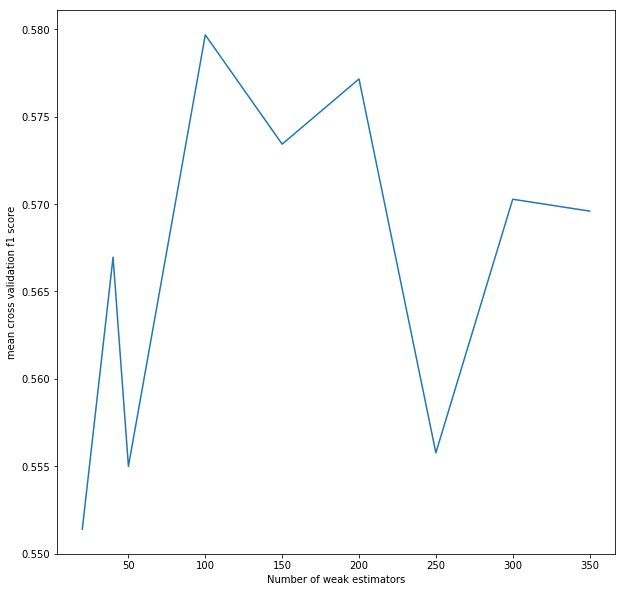

100

In [23]:
ntree_vals = [20,40, 50, 100, 150, 200, 250, 300, 350]
reg_plot(ntree_vals, X_train, y_train)

This is a good start, but this classifier type has a large number of tuneable hyperparameters which may help us. In this project, we focus just on `n_trees` and `max_depth` due to computational and time constraints.

In [26]:
# measure performance of gbm using different values for ntrees and max_depth
def param_search(ntree_vals, md_vals, X_train, y_train, resample = True):
    scores = np.zeros((len(ntree_vals), len(md_vals)))
    print "Running 7-fold cross validation for:"
    for i in range(len(ntree_vals)):
        for j in range(len(md_vals)):
            print "n_trees = %d," % ntree_vals[i],
            print "max_depth = %d," % md_vals[j]
            evalgbm = EvalGBM(X_train, y_train, n_estimators = ntree_vals[i], max_depth = md_vals[j], metric = 'roc')
            scores[i,j] = np.mean(evalgbm.kfold(7, False, False, resample).Test_score)

    print scores
    score_opt = scores.max()
    params_opt = np.where(scores==score_opt)
    
    return (score_opt, params_opt)

In [27]:
# perform 2D grid search over a subset of hyperparameter values
ntree_vals = (20,40,60,80)
md_vals = (1,2,3,4)
param_search(ntree_vals, md_vals, X_train, y_train, resample = True)

Running 7-fold cross validation for:
n_trees = 20, max_depth = 1,
n_trees = 20, max_depth = 2,
n_trees = 20, max_depth = 3,
n_trees = 20, max_depth = 4,
n_trees = 40, max_depth = 1,
n_trees = 40, max_depth = 2,
n_trees = 40, max_depth = 3,
n_trees = 40, max_depth = 4,
n_trees = 60, max_depth = 1,
n_trees = 60, max_depth = 2,
n_trees = 60, max_depth = 3,
n_trees = 60, max_depth = 4,
n_trees = 80, max_depth = 1,
n_trees = 80, max_depth = 2,
n_trees = 80, max_depth = 3,
n_trees = 80, max_depth = 4,
[[ 0.53887244  0.5472458   0.57005855  0.55613323]
 [ 0.56016243  0.55378907  0.56511928  0.58535863]
 [ 0.58471518  0.57066838  0.58668301  0.5521375 ]
 [ 0.55890869  0.55923667  0.55958902  0.56362061]]


(0.58668301328366201, (array([2]), array([2])))

In [34]:
# preliminary code to start looking at feature selection
evalgbm = EvalGBM(X_train, y_train, n_estimators = 60, max_depth = 3)
rXtrain, rytrain = evalgbm.resample(X_train, y_train, False)
evalgbm.gbm.fit(rXtrain, rytrain)
features = list(X_train.columns.values)
print features[np.argmax(evalgbm.gbm.feature_importances_)]

RP11-404K5.2


# Testing

Based on the tuning results above, a model of 40 estimators with a max-depth of two should ouperform our basic model. Here, we train and test that model


Optimum threshold to maximize f1: 0.475003057629
Train Score: 0.760369 Test Score: 0.656341
AU-ROC: 0.543188827914
Accuracy: 0.568126520681
Confusion Matrix:
[[128 283]
 [ 72 339]]


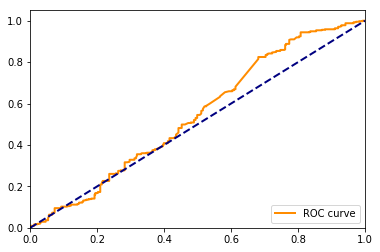

In [36]:
evalgbm = EvalGBM(X_train, y_train, n_estimators = 60, max_depth = 3)
rXtrain, rytrain = evalgbm.resample(X_train, y_train, False)
rXtest, rytest = evalgbm.resample(X_test, y_test, False)
evalgbm.setTrain(rXtrain, np.asarray(rytrain))
evalgbm.setTest(rXtest, rytest)


from sklearn.metrics import roc_curve, f1_score, confusion_matrix, roc_auc_score, accuracy_score
# fit to train data
evalgbm.gbm.fit(rXtrain, rytrain)

test_probs = evalgbm.gbm.predict_proba(rXtest)[:,1]
train_probs = evalgbm.gbm.predict_proba(rXtrain)[:,1]

fpr, tpr, thresholds = roc_curve(rytrain, train_probs, pos_label = 1)
f1s = [f1_score(rytrain, (train_probs>t).astype(int), average = 'binary') for t in thresholds]
f_i = np.argmax(np.asarray(f1s))

test_probs_f = (test_probs>thresholds[f_i]).astype(int)
print "\nOptimum threshold to maximize f1:", thresholds[f_i]
trainscore = f1_score(rytrain, (train_probs>thresholds[f_i]).astype(int), average = 'binary')
testscore = f1_score(rytest, test_probs_f, average = 'binary')

print "Train Score: %f Test Score: %f" % (trainscore, testscore)

print "AU-ROC:", roc_auc_score(rytest, test_probs)
print "Accuracy:", accuracy_score(rytest, test_probs_f)
print "Confusion Matrix:\n", confusion_matrix(rytest, test_probs_f)

plt.figure()
lw = 2


fpr, tpr, thresholds = roc_curve(rytest, test_probs, pos_label = 1)
plt.plot(fpr, tpr, color = 'darkorange', lw = lw, label = 'ROC curve')
plt.plot([0,1], [0,1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.legend(loc='lower right')
plt.show()
plt.figure(figsize = (10,10))


# Bagging

Perhaps we can combine the LR and GBM classifiers to achieve even better performance.


Optimum threshold to maximize f1: 0.490545700888
Train Score: 0.737999 Test Score: 0.589114
AU-ROC: 0.54752517449
Accuracy: 0.531630170316
Confusion Matrix:
[[161 250]
 [135 276]]


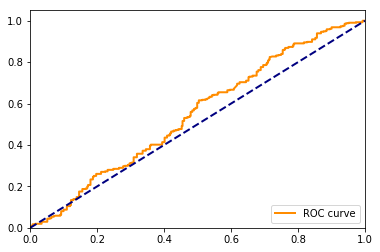

In [37]:
# Import EvalLR
import class_EvalLR
reload(class_EvalLR)
from class_EvalLR import EvalLR

# train our best LR classifier
evalr = EvalLR(X_train, y_train, c=0.125)
evalr.lr.fit(rXtrain, rytrain)
test_probs_lr = evalr.lr.predict_proba(rXtest)[:,1]
train_probs_lr = evalr.lr.predict_proba(rXtrain)[:,1]

# average predictions for both classifiers
test_probs_bg = (test_probs_lr + test_probs)/2
train_probs_bg = (train_probs_lr + train_probs)/2

# evaluate bagged classifier
fpr, tpr, thresholds = roc_curve(rytrain, train_probs_bg, pos_label = 1)
f1s = [f1_score(rytrain, (train_probs_bg>t).astype(int), average = 'binary') for t in thresholds]
f_i = np.argmax(np.asarray(f1s))

test_probs_f = (test_probs_bg>thresholds[f_i]).astype(int)
print "\nOptimum threshold to maximize f1:", thresholds[f_i]
trainscore = f1_score(rytrain, (train_probs_bg>thresholds[f_i]).astype(int), average = 'binary')
testscore = f1_score(rytest, test_probs_f, average = 'binary')

print "Train Score: %f Test Score: %f" % (trainscore, testscore)

print "AU-ROC:", roc_auc_score(rytest, test_probs_bg)
print "Accuracy:", accuracy_score(rytest, test_probs_f)
print "Confusion Matrix:\n", confusion_matrix(rytest, test_probs_f)

plt.figure()
lw = 2


fpr, tpr, thresholds = roc_curve(rytest, test_probs_bg, pos_label = 1)
plt.plot(fpr, tpr, color = 'darkorange', lw = lw, label = 'ROC curve')
plt.plot([0,1], [0,1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.legend(loc='lower right')
plt.show()
plt.figure(figsize = (10,10))

In [39]:
ssc_subjects = list(set(SSC_asd.index.values.tolist() + SSC_ctrl.index.values.tolist()) & set(subjects))
agre_subjects = list(set(Agre_asd.index.values.tolist() + Agre_ctrl.index.values.tolist()) & set(subjects))

ssc_test_subjects = list(set(ssc_subjects) & set(rytest.index.values.tolist()))
agre_test_subjects = list(set(agre_subjects) & set(rytest.index.values.tolist()))

print len(ssc_subjects)
print len(agre_subjects)

ssc_ytest = rytest.ix[ssc_test_subjects]
ssc_Xtest = rXtest.ix[ssc_test_subjects]

agre_ytest = rytest.ix[agre_test_subjects]
agre_Xtest = rXtest.ix[agre_test_subjects]

1032
1963


As a final check, measure performance separately on the SSC and Agre members of the test set.

AU-ROC: 0.528968084694


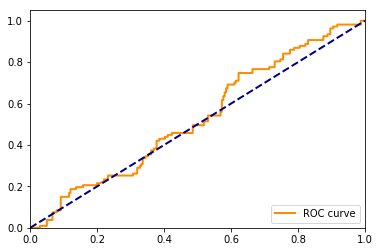

In [40]:
# results for ssc
test_probs_lr = evalr.lr.predict_proba(ssc_Xtest)[:,1]
test_probs = evalgbm.gbm.predict_proba(ssc_Xtest)[:,1]

# average predictions for both classifiers
test_probs_bg = (test_probs_lr + test_probs)/2

print "AU-ROC:", roc_auc_score(ssc_ytest, test_probs_bg)

plt.figure()
lw = 2

fpr, tpr, thresholds = roc_curve(ssc_ytest, test_probs_bg, pos_label = 1)
plt.plot(fpr, tpr, color = 'darkorange', lw = lw, label = 'ROC curve')
plt.plot([0,1], [0,1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.legend(loc='lower right')
plt.show()
plt.figure(figsize = (10,10))

AU-ROC: 0.460623065015


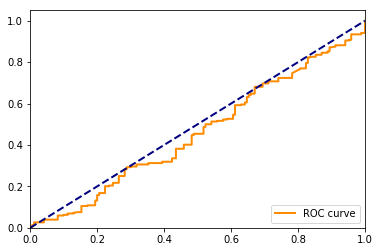

In [41]:
# results for agre
test_probs_lr = evalr.lr.predict_proba(agre_Xtest)[:,1]
test_probs = evalgbm.gbm.predict_proba(agre_Xtest)[:,1]

# average predictions for both classifiers
test_probs_bg = (test_probs_lr + test_probs)/2

print "AU-ROC:", roc_auc_score(agre_ytest, test_probs_bg)

plt.figure()
lw = 2

fpr, tpr, thresholds = roc_curve(agre_ytest, test_probs_bg, pos_label = 1)
plt.plot(fpr, tpr, color = 'darkorange', lw = lw, label = 'ROC curve')
plt.plot([0,1], [0,1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.legend(loc='lower right')
plt.show()
plt.figure(figsize = (10,10))